# Imports, quick feature engineering, and quick look at data

In [1]:
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, NearMiss
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier

# plot_confusion_matrix(rf, x_train, y_train, values_format='d')

# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 1000)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# set a seed for reproducibility
RANDOM_STATE = 99

In [4]:
df = pd.read_csv('RFE_Estimate_WGs.csv')

#convert RFE_SUBMITE_DATE to datetime variable
df['RFE_SUBMIT_DATE'] = pd.to_datetime(df.RFE_SUBMIT_DATE)

# convert IDs into a string so they are treated as categorical
# also add details to each ID so they are not confused later on
df['SUPPLIER_USER_ID'] = df['SUPPLIER_USER_ID'].astype(str) + 'supplier'
df['SP_SPEC_TYPE_ID'] = df['SP_SPEC_TYPE_ID'].astype(str) + 'sp_spec'
df['PRODUCT_TYPE_ID'] = df['PRODUCT_TYPE_ID'].astype(str) + 'product'

# adding new variables for time features
df['month'] = [i.month_name() for i in df['RFE_SUBMIT_DATE']]
df['dayofweek'] = [i.day_name() for i in df['RFE_SUBMIT_DATE']]
df['weekday'] = [0 if i in ['Saturday', 'Sunday'] else 1 for i in df['dayofweek']]

As the columns for weekday and dayofweek are really similar, only one should be included in the final model.  We will quickly look at their effects on IS_SUBMIT_ESTIMATE and decide which one to include.

In [5]:
weekday_df = pd.crosstab(df.weekday, df.IS_SUBMIT_ESTIMATE, margins=True)
weekday_df['percentages'] = weekday_df[1] / weekday_df['All']
weekday_df

IS_SUBMIT_ESTIMATE,0,1,All,percentages
weekday,,,,
0,425,30,455,0.065934
1,63024,5622,68646,0.081898
All,63449,5652,69101,0.081793


In [6]:
dayofweek_df = pd.crosstab(df.dayofweek, df.IS_SUBMIT_ESTIMATE, margins=True)
dayofweek_df['percentages'] = dayofweek_df[1] / dayofweek_df['All']
dayofweek_df

IS_SUBMIT_ESTIMATE,0,1,All,percentages
dayofweek,,,,
Friday,13021,1188,14209,0.083609
Monday,12691,1103,13794,0.079962
Saturday,304,14,318,0.044025
Sunday,121,16,137,0.116788
Thursday,10754,998,11752,0.084922
Tuesday,13492,1182,14674,0.080551
Wednesday,12388,1151,13539,0.085014
All,62771,5652,68423,0.082604


We see that all 5 weekdays are relatively similar (around 8%) while Saturday and Sunday are both drastically different.  Saturday is much lower than the weekdays and Sundays are much higher than the weekdays.  Even with the caveat that both happen much less often than weekdays, this is still a significant difference.

It would have been most explainable for Saturday and Sunday to both have lower percentages of IS_SUBMIT_ESTIMATE since it could have meant that suppliers have lower response rates during the weekend but, strangely, this is not the case.  There are probably other factors at play for Sunday to have such a high rate of percentage of IS_SUBMIT_ESTIMATE, but they are not reflected in this dataset.

For modeling, we will use the day of week variable since that would not group Saturday and Sunday together.

In [7]:
# removing the RFE_ID and RFE_OWNER_WORKGROUP_ID and RFE_SUBMIT_DATE
df = df[['SUPPLIER_USER_ID', 'PROPOSED_COMPLETION_HOURS', 'ESTIMATE_DUE_HOURS',
         'RFE_ITEM_CONUT', 'PRODUCT_TYPE_ID', 'SP_SPEC_TYPE_ID',
         'RFE_QUANTITY_1', 'RFE_QUANTITY_2', 'RFE_QUANTITY_3', 'RFE_QUANTITY_4',
         'RFE_QUANTITY_5', 'IS_SUBMIT_ESTIMATE', 'month', 'dayofweek']]


In [8]:
df.head()

,SUPPLIER_USER_ID,PROPOSED_COMPLETION_HOURS,ESTIMATE_DUE_HOURS,RFE_ITEM_CONUT,PRODUCT_TYPE_ID,SP_SPEC_TYPE_ID,RFE_QUANTITY_1,RFE_QUANTITY_2,RFE_QUANTITY_3,RFE_QUANTITY_4,RFE_QUANTITY_5,IS_SUBMIT_ESTIMATE,month,dayofweek
0,5454075supplier,364.0,100.0,1,4000500product,5002011sp_spec,500,NaN,NaN,NaN,NaN,0,March,Thursday
1,5425218supplier,364.0,100.0,1,4000500product,5002011sp_spec,500,NaN,NaN,NaN,NaN,0,March,Thursday
2,5425565supplier,364.0,100.0,1,4000500product,5002011sp_spec,500,NaN,NaN,NaN,NaN,0,March,Thursday
3,5430764supplier,364.0,100.0,1,4000500product,5002011sp_spec,500,NaN,NaN,NaN,NaN,0,March,Thursday
4,5432936supplier,364.0,100.0,1,4000500product,5002011sp_spec,500,NaN,NaN,NaN,NaN,1,March,Thursday


In [9]:
df.describe(include='all')

,SUPPLIER_USER_ID,PROPOSED_COMPLETION_HOURS,ESTIMATE_DUE_HOURS,RFE_ITEM_CONUT,PRODUCT_TYPE_ID,SP_SPEC_TYPE_ID,RFE_QUANTITY_1,RFE_QUANTITY_2,RFE_QUANTITY_3,RFE_QUANTITY_4,RFE_QUANTITY_5,IS_SUBMIT_ESTIMATE,month,dayofweek
count,69101,68423.000000,68423.000000,69101.000000,69101,69101,69101.000000,1.949000e+04,9580.000000,3156.000000,360.000000,69101.000000,68423,68423
unique,358,NaN,NaN,NaN,47,7,NaN,NaN,NaN,NaN,NaN,NaN,12,7
top,5451014supplier,NaN,NaN,NaN,4000057product,5001052sp_spec,NaN,NaN,NaN,NaN,NaN,NaN,December,Tuesday
freq,657,NaN,NaN,NaN,14569,61910,NaN,NaN,NaN,NaN,NaN,NaN,9763,14674
mean,NaN,1386.057758,85.748067,1.023097,NaN,NaN,34818.207247,3.677723e+04,34453.563987,36070.888466,11681.472222,0.081793,NaN,NaN
std,NaN,844.253928,54.569768,0.150212,NaN,NaN,92428.755904,1.249910e+05,68529.517224,71840.947926,13051.385968,0.274052,NaN,NaN
min,NaN,22.000000,0.000000,1.000000,NaN,NaN,1.000000,2.000000e+00,3.000000,4.000000,5.000000,0.000000,NaN,NaN
25%,NaN,798.000000,48.000000,1.000000,NaN,NaN,1691.000000,1.500000e+03,1000.000000,1000.000000,100.000000,0.000000,NaN,NaN
50%,NaN,1226.000000,73.000000,1.000000,NaN,NaN,6000.000000,6.300000e+03,5000.000000,6000.000000,7000.000000,0.000000,NaN,NaN
75%,NaN,1781.000000,116.000000,1.000000,NaN,NaN,20000.000000,2.000000e+04,30000.000000,30000.000000,9000.000000,0.000000,NaN,NaN


In [10]:
print('Total observations where IS_SUBMIT_ESTIMATE is 1 is ',
      sum(df.IS_SUBMIT_ESTIMATE))

print('Percentage of these observations of the whole dataset is',
      sum(df.IS_SUBMIT_ESTIMATE) / len(df))

Total observations where IS_SUBMIT_ESTIMATE is 1 is  5652
Percentage of these observations of the whole dataset is 0.08179331702869712


# Initial/Benchmark Models

We will begin with initial models fitting all variables on the predictor to provide a benchmark model.  We will look at logistic regression, naive bayes, random forest, and XGBoost.  XGBoost is the only algorithm out of the above that can handle missing values, so all other algorithms will use data where the missing quantity observations are filled with a 0.

Due to the imbalance in the dataset for the "IS_SUBMIT_ESTIMATE" variable, we will use not only accuracy, but also the following metrics to evaluate the models.

*  Precision - the number of items correctly identified as positive (or 1 for IS_SUBMIT_ESTIMATE) out of all items predicted as positive.
*  Recall - number of items correctly identified as positive out of all true positives
* F1 Score- harmonic mean of precision and recall (2 * precision * Recall) / (Precision + Recall)

We start by first encoding all of the categorical variables with one-hot encoding.

PRODUCT_TYPE_ID, SP_SPEC_TYPE_ID, and SUPPLIER_USER_ID have no missing values, so one category will be dropped as the one-hot coding for them will provide the same information if one category is not dropped compared to if it dropped.
Month and dayofweek, however, have missing variables, so all categories must be present.

Due to the fact that SUPPLIER_USER_ID contains 358 different categories, using one-hot encoding will result in a very sparse matrix, increasing training time.  Target encoding was used at first (not shown in this notebook), but resulted in too much overfitting.  The models put practically all the weight on that variable and the testing f_scores were lower, so one-hot encoding will still be used.

In [11]:
# getting df with proper encodings

# first get list of categorical variables to be one hot encoded
# categorical variables with no missing variables
dummy_cat = ['PRODUCT_TYPE_ID', 'SP_SPEC_TYPE_ID', 'SUPPLIER_USER_ID']
# categorical variables with missing variables
dummy_cat_miss = ['month', 'dayofweek']

# get list for num variables
# adding 'SUPPLIER_USER_ID' to encode later
num_vars = ['PROPOSED_COMPLETION_HOURS', 'ESTIMATE_DUE_HOURS', 'RFE_ITEM_CONUT',
            'RFE_QUANTITY_1', 'RFE_QUANTITY_2', 'RFE_QUANTITY_3',
            'RFE_QUANTITY_4', 'RFE_QUANTITY_5']

# get the predicted variable
y = df.IS_SUBMIT_ESTIMATE

# initialize df of numerical data
X = df[num_vars]

# dummify categorical variables
# also dropping the first column since the information does not change if
# all the other columns are kept
for i in dummy_cat:
  X = X.join(pd.get_dummies(df[i]).iloc[:, 1:], rsuffix=i)

# dummify categorical variables with missing variables and keeping all columns
for i in dummy_cat_miss:
  X = X.join(pd.get_dummies(df[i]).iloc[:, :], rsuffix=i)

In [12]:
X.head()

,PROPOSED_COMPLETION_HOURS,ESTIMATE_DUE_HOURS,RFE_ITEM_CONUT,RFE_QUANTITY_1,RFE_QUANTITY_2,RFE_QUANTITY_3,RFE_QUANTITY_4,RFE_QUANTITY_5,4000055product,4000056product,4000057product,4000064product,4000065product,4000070product,4000077product,4000079product,4000081product,4000084product,4000085product,4000092product,4000093product,4000094product,4000095product,4000101product,4000113product,4000114product,4000120product,4000141product,4000164product,4000228product,4000253product,4000263product,4000264product,4000269product,4000290product,4000292product,4000500product,5021345product,5021351product,5021357product,...,5612275supplier,5612294supplier,5612435supplier,5612457supplier,5612617supplier,5612895supplier,5613435supplier,5615694supplier,5615794supplier,5616202supplier,5616494supplier,5616874supplier,5617755supplier,5618015supplier,5618376supplier,5618755supplier,5618756supplier,5618757supplier,5618954supplier,5619175supplier,5620974supplier,April,August,December,February,January,July,June,March,May,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,364.0,100.0,1,500,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,364.0,100.0,1,500,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,364.0,100.0,1,500,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,364.0,100.0,1,500,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,364.0,100.0,1,500,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


With the predictor variables now properly encoded, we will now split the dataset into a testing and training set.  All future changes in the modeling will be done only on the training set.



In [13]:
x_train, x_test, y_train, y_test =  train_test_split(X, y,
                                                     test_size=.33,
                                                     random_state = RANDOM_STATE)

In [14]:
# getting training and testing set for the predictor variables with quantity
# filled in with 0s

# dict with columns and what value to fill
# PROPOSED_COMPLETION_HOURS and ESTIMATE_DUE_HOURS will be filled by their mean
# quantity columns will be filled with 0
values = {'PROPOSED_COMPLETION_HOURS' : df['PROPOSED_COMPLETION_HOURS'].mean(),
          'ESTIMATE_DUE_HOURS' : df['ESTIMATE_DUE_HOURS'].mean(),
          'RFE_QUANTITY_2' : 0, 'RFE_QUANTITY_3' : 0, 'RFE_QUANTITY_4' : 0,
          'RFE_QUANTITY_5' : 0}

x_train = x_train.fillna(value = values)
x_test = x_test.fillna(value = values)

In [15]:
# function to print scores for training and test sets
score_cols=['Train_acc', 'Train_prec', 'Train_recall', 'Train_fscore',
            'Test_acc','Test_prec', 'Test_recall', 'Test_fscore',
            'Model', 'Model_version']
all_scores = pd.DataFrame(columns=score_cols)

def get_scores(train_pred, test_pred, y_train, y_test, mod, version):
  scores_train = precision_recall_fscore_support(y_train, train_pred,
                                                 average='binary')
  acc_train = sum(train_pred == y_train) / len(y_train)
  prec_train = scores_train[0]
  recall_train = scores_train[1]
  f_score_train = scores_train[2]

  scores_test = precision_recall_fscore_support(y_test, test_pred,
                                                average='binary')
  acc_test = sum(test_pred == y_test) / len(y_test)
  prec_test = scores_test[0]
  recall_test = scores_test[1]
  f_score_test = scores_test[2]

  scores = [acc_train, prec_train, recall_train, f_score_train, 
            acc_test, prec_test, recall_test, f_score_test,
            mod, version]

  df_score = pd.DataFrame(np.reshape(scores, newshape=(1,10)),
                          columns=score_cols)
  return df_score

In [16]:
# run a benchmark XGboost model

xgb_bench = XGBClassifier(random_state=RANDOM_STATE)
xgb_bench.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=99,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [17]:
# get xgboost predictions on the training set and test set
x_train_xgb_pred_bench = xgb_bench.predict(x_train)
x_test_xgb_pred_bench = xgb_bench.predict(x_test)

In [18]:
# run a benchmark logistic regression model

lr_bench = LogisticRegression(random_state=RANDOM_STATE, C=.3)
lr_bench.fit(x_train, y_train)

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=99, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
# get logistic regression predictions on the training set and test set
x_train_lr_pred_bench = lr_bench.predict(x_train)
x_test_lr_pred_bench = lr_bench.predict(x_test)

In [20]:
# run a benchmark naive_bayes model

nb_bench = MultinomialNB()
nb_bench.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [21]:
# get naive bayes predictions on the training set and test set
x_train_nb_pred_bench = nb_bench.predict(x_train)
x_test_nb_pred_bench = nb_bench.predict(x_test)

In [22]:
# run a benchmark random forest model

rf_bench = RandomForestClassifier(random_state=RANDOM_STATE)
rf_bench.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=99, verbose=0,
                       warm_start=False)

In [23]:
# get random forest predictions on the training set and test set
x_train_rf_pred_bench = rf_bench.predict(x_train)
x_test_rf_pred_bench = rf_bench.predict(x_test)

## Benchmark Model comparisons

In [24]:
all_scores = all_scores.append(get_scores(x_train_rf_pred_bench, x_test_rf_pred_bench, y_train, y_test, 'rf', 'benchmark'))
all_scores = all_scores.append(get_scores(x_train_xgb_pred_bench, x_test_xgb_pred_bench, y_train, y_test, 'xgb', 'benchmark'))
all_scores = all_scores.append(get_scores(x_train_lr_pred_bench, x_test_lr_pred_bench, y_train, y_test, 'lr', 'benchmark'))
all_scores = all_scores.append(get_scores(x_train_nb_pred_bench, x_test_nb_pred_bench, y_train, y_test, 'nb', 'benchmark'))
all_scores.set_index(['Model_version', 'Model'])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train_acc  ...          Test_fscore
Model_version Model                       ...                     
benchmark     rf      0.9997408039397802  ...   0.6342088404868674
              xgb     0.9340346026740394  ...  0.33232628398791536
              lr      0.9180724452988315  ...                  0.0
              nb     0.32801261420826405  ...   0.1498143699497707

[4 rows x 8 columns]

The Test_fscore is the most important metric, as it shows how well a model performs on data it hasn't seen and is a combination of the precision and recall.  The accuracies seem high across the differenbt models (except naive bayes) but, due to the data have such an imbalanced IS_SUBMIT_ESTIMATE, a model could predict everything as a 0 for IS_SUBMIT_ESTIMATE and wind up with a high accuracy.  Therefore, accuracy is not a great metric.

It seems that logistic regression and naive bayes perform the most poorly, with logistic regression running into errors calculating scores due to the fact that the algorithm is outputting all 0s.

The random forest model fares much better on the training set compared to xgboost with an fscore of almost 1.  However, the fact that the testing sets are relatively similar shows how much the random forest model is overfitting on the data.

We will proceed by balancing the data and then looking at both xgboost and random forest models.

# Balancing data - can skip to comparing all scores section to see results

With only 8% of the observations having an "IS_SUBMIT_ESTIMATE" of 1, this is very imbalanced dataset.  As this is troublesome for machine learning models, we will proceed by balancing the class distributions with different techniques and compare their effects.  The class balancing will only occur on the training set.

**A csv has been saved with all the scores so retraining all the models to get the scores for different balancing methods will not be needed.  This csv is called 'balancing_scores.csv'.  Therefore all the code can be commented out except for the ones that perform the best.**

## Smote

Our first class balancing techqnique will be SMOTE (synthetic minority oversampling technique).

On a high level, SMOTE randomly picks a point from the minority class and computes KNN on it.  New synthetic points are added between this point and the neighbors, which increases instances of the minority class, hence being an oversampling technique.  

In [25]:
smote = SMOTE(random_state=RANDOM_STATE)
smote_x, smote_y = smote.fit_resample(x_train, y_train)
smote_x = pd.DataFrame(data=smote_x, columns=x_train.columns)
smote_y = pd.Series(data=smote_y, name = 'IS_SUBMIT_ESTIMATE')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [26]:
# run a forest model on smote-balanced data
rf_smote = RandomForestClassifier(random_state=RANDOM_STATE)
rf_smote.fit(smote_x, smote_y)

# get random forest predictions on the training set and test set
x_train_rf_pred_smote = rf_smote.predict(smote_x)
x_test_rf_pred_smote = rf_smote.predict(x_test)

In [27]:
# # run XGboost model on smote-balanced data
# xgb_smote = XGBClassifier(random_state=RANDOM_STATE)
# xgb_smote.fit(smote_x, smote_y)

# # get xgboost predictions on the training set and test set
# x_train_xgb_pred_smote = xgb_smote.predict(smote_x)
# x_test_xgb_pred_smote = xgb_smote.predict(x_test)

In [28]:
# # run logistic regression model on smote-balanced data
# lr_smote = LogisticRegression(random_state=RANDOM_STATE)
# lr_smote.fit(smote_x, smote_y)

# # get logistic regression predictions on the training set and test set
# x_train_lr_pred_smote = lr_smote.predict(smote_x)
# x_test_lr_pred_smote = lr_smote.predict(x_test)

In [29]:
# # run Naive Bayes model on smote-balanced data
# nb_smote = MultinomialNB()
# nb_smote.fit(smote_x, smote_y)

# # get logistic regression predictions on the training set and test set
# x_train_nb_pred_smote = nb_smote.predict(smote_x)
# x_test_nb_pred_smote = nb_smote.predict(x_test)

In [30]:
# all_scores = all_scores.append(get_scores(x_train_rf_pred_smote, x_test_rf_pred_smote, smote_y, y_test, 'rf', 'smote'))
# all_scores = all_scores.append(get_scores(x_train_xgb_pred_smote, x_test_xgb_pred_smote, smote_y, y_test, 'xgb', 'smote'))
# all_scores = all_scores.append(get_scores(x_train_lr_pred_smote, x_test_lr_pred_smote, smote_y, y_test, 'lr', 'smote'))
# all_scores = all_scores.append(get_scores(x_train_nb_pred_smote, x_test_nb_pred_smote, smote_y, y_test, 'nb', 'smote'))
# all_scores.set_index(['Model_version', 'Model'])

## Tomek links

A Tomek links is a pair of observations that are are close together, but have different classes.  By removing the majority class within a pair, we can undersample the data.

In [31]:
# tl = TomekLinks(sampling_strategy='majority')
# tl_x, tl_y = tl.fit_resample(x_train, y_train)
# tl_x = pd.DataFrame(data = tl_x, columns = x_train.columns)
# tl_y = pd.Series(data=tl_y, name = 'IS_SUBMIT_ESTIMATE')

In [32]:
# # run a random forest model on Token link-balanced data
# rf_tl = RandomForestClassifier(random_state=RANDOM_STATE)
# rf_tl.fit(tl_x, tl_y)
# # get random forest predictions on the training set and test set
# x_train_rf_pred_tl = rf_tl.predict(tl_x)
# x_test_rf_pred_tl = rf_tl.predict(x_test)

# # run XGboost model on Token link-balanced data
# xgb_tl = XGBClassifier(random_state=RANDOM_STATE)
# xgb_tl.fit(tl_x, tl_y)
# # get xgboost predictions on the training set and test set
# x_train_xgb_pred_tl = xgb_tl.predict(tl_x)
# x_test_xgb_pred_tl = xgb_tl.predict(x_test)

# # run logistic regression model on Token link-balanced data
# lr_tl = LogisticRegression(random_state=RANDOM_STATE)
# lr_tl.fit(tl_x, tl_y)
# # get logistic regression predictions on the training set and test set
# x_train_lr_pred_tl = lr_tl.predict(tl_x)
# x_test_lr_pred_tl = lr_tl.predict(x_test)

# # run Naive Bayes model on Token link-balanced data
# nb_tl = MultinomialNB()
# nb_tl.fit(tl_x, tl_y)
# # get logistic regression predictions on the training set and test set
# x_train_nb_pred_tl = nb_tl.predict(tl_x)
# x_test_nb_pred_tl = nb_tl.predict(x_test)

## NearMiss


We can look at NearMiss, another undersampling technique.  This algorithm eliminates observations in the majority class based on distance between points.

In [33]:
# nm = NearMiss(sampling_strategy='majority')
# nm_x, nm_y = nm.fit_resample(x_train, y_train)
# nm_x = pd.DataFrame(data = nm_x, columns = x_train.columns)
# nm_y = pd.Series(data=nm_y, name = 'IS_SUBMIT_ESTIMATE')

In [34]:
# # run a random forest model on Token link-balanced data
# rf_nm = RandomForestClassifier(random_state=RANDOM_STATE)
# rf_nm.fit(nm_x, nm_y)
# # get random forest predictions on the training set and test set
# x_train_rf_pred_nm = rf_nm.predict(nm_x)
# x_test_rf_pred_nm = rf_nm.predict(x_test)

# # run XGboost model on Token link-balanced data
# xgb_nm = XGBClassifier(random_state=RANDOM_STATE)
# xgb_nm.fit(nm_x, nm_y)
# # get xgboost predictions on the training set and test set
# x_train_xgb_pred_nm = xgb_nm.predict(nm_x)
# x_test_xgb_pred_nm = xgb_nm.predict(x_test)

# # run logistic regression model on Token link-balanced data
# lr_nm = LogisticRegression(random_state=RANDOM_STATE)
# lr_nm.fit(nm_x, nm_y)
# # get logistic regression predictions on the training set and test set
# x_train_lr_pred_nm = lr_nm.predict(nm_x)
# x_test_lr_pred_nm = lr_nm.predict(x_test)

# # run Naive Bayes model on Token link-balanced data
# nb_nm = MultinomialNB()
# nb_nm.fit(nm_x, nm_y)
# # get logistic regression predictions on the training set and test set
# x_train_nb_pred_nm = nb_nm.predict(nm_x)
# x_test_nb_pred_nm = nb_nm.predict(x_test)

## SmoteTomek

The last balancing method we will look at is Smote Tomek.  It essentially combines Smote and Tomek links by first using SMOTE then cleaning with Tomek Links.

In [35]:
smo_tl = SMOTETomek(random_state=RANDOM_STATE)
smo_tl_x, smo_tl_y = smo_tl.fit_resample(x_train, y_train)
smo_tl_x = pd.DataFrame(data = smo_tl_x, columns = x_train.columns)
smo_tl_y = pd.Series(data=smo_tl_y, name = 'IS_SUBMIT_ESTIMATE')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [36]:
# run a random forest model on Token link-balanced data
rf_smo_tl = RandomForestClassifier(random_state=RANDOM_STATE)
rf_smo_tl.fit(smo_tl_x, smo_tl_y)
# get random forest predictions on the training set and test set
x_train_rf_pred_smo_tl = rf_smo_tl.predict(smo_tl_x)
x_test_rf_pred_smo_tl = rf_smo_tl.predict(x_test)

# # run XGboost model on Token link-balanced data
# xgb_smo_tl = XGBClassifier(random_state=RANDOM_STATE)
# xgb_smo_tl.fit(smo_tl_x, smo_tl_y)
# # get xgboost predictions on the training set and test set
# x_train_xgb_pred_smo_tl = xgb_smo_tl.predict(smo_tl_x)
# x_test_xgb_pred_smo_tl = xgb_smo_tl.predict(x_test)

# # run logistic regression model on Token link-balanced data
# lr_smo_tl = LogisticRegression(random_state=RANDOM_STATE)
# lr_smo_tl.fit(smo_tl_x, smo_tl_y)
# # get logistic regression predictions on the training set and test set
# x_train_lr_pred_smo_tl = lr_smo_tl.predict(smo_tl_x)
# x_test_lr_pred_smo_tl = lr_smo_tl.predict(x_test)

# # run Naive Bayes model on Token link-balanced data
# nb_smo_tl = MultinomialNB()
# nb_smo_tl.fit(smo_tl_x, smo_tl_y)
# # get logistic regression predictions on the training set and test set
# x_train_nb_pred_smo_tl = nb_smo_tl.predict(smo_tl_x)
# x_test_nb_pred_smo_tl = nb_smo_tl.predict(x_test)

## Comparing all scores

In [37]:
# # saving scores so we don't need to retrain all predictors again to
# # get the scores

# all_scores.to_csv('balancing_scores.csv')

In [38]:
# Getting previously saved csv of all the scores.

all_scores = pd.read_csv('balancing_scores.csv')
all_scores.set_index(['Model_version', 'Model'])

Unnamed: 0  Train_acc  ...  Test_recall  Test_fscore
Model_version Model                         ...                          
benchmark     rf              0   0.999741  ...     0.532544     0.634209
              xgb             0   0.934035  ...     0.207101     0.332326
              lr              0   0.918072  ...     0.000000     0.000000
              nb              0   0.328013  ...     0.738031     0.149814
smote         rf              0   0.999859  ...     0.561592     0.645241
              xgb             0   0.911326  ...     0.359333     0.477996
              lr              0   0.514716  ...     0.535234     0.149759
              nb              0   0.524245  ...     0.760086     0.151455
tl            rf              0   0.999697  ...     0.530931     0.631882
              xgb             0   0.934118  ...     0.220011     0.348530
              lr              0   0.917826  ...     0.000000     0.000000
              nb              0   0.327311  ...     0.738031     0.149635
nm            rf              0   0.998682  ...     0.861754     0.437944
              xgb             0   0.816109  ...     0.674556     0.543445
              lr              0   0.499868  ...     0.068854     0.078939
              nb              0   0.506327  ...     0.871436     0.148352
smo_tl        rf              0   0.999859  ...     0.568047     0.647059
              xgb             0   0.911382  ...     0.359333     0.477996
              lr              0   0.514519  ...     0.533620     0.149364
              nb              0   0.524261  ...     0.760624     0.151546

[20 rows x 9 columns]

Tree based models (such as random forest and xgboost) naturally already work well with imbalanced datasets, so it is not surprising that, with some of the balancing methods, they both suffered on the testing set as their Test_fscore went lower.

For the two non-tree based models we looked at (logistic regression and naive bayes), it seems that using all balancing methods improved or at least didn't really affect the f score for the testing set.

It seems that the random forest model trained on data balanced with SMOTE Tomek performs the best, with SMOTE also doing well.  We will therefore proceed with this model and these two data balancing techniques.


# Feature Engineering

With an ideal method of balancing the dataset found, we can move onto feature engineering.  We can start by looking at the most important variables for the random forest and xgboost models.

**As with the scores for different balancing methods, we will also save a csv of the best scores from feature engineering so models will not need to be retrained.**

In [39]:
# Random forest features for SMOTE_TL
rf_smo_tl_feat_imp = pd.DataFrame(smo_tl_x.columns, columns=['Predictor'])
rf_smo_tl_feat_imp['feat_imp'] = rf_smo_tl.feature_importances_
# only getting variables with greater than .01 feature importance
rf_smo_tl_feat_imp = rf_smo_tl_feat_imp[rf_smo_tl_feat_imp.feat_imp > .01]
rf_smo_tl_feat_imp.sort_values(['feat_imp'], axis=0, 
                              ascending=False, inplace=True)

# Random forest features for Smote
rf_smote_feat_imp = pd.DataFrame(smote_x.columns, columns=['Predictor'])
rf_smote_feat_imp['feat_imp'] = rf_smote.feature_importances_
# # only getting variables with greater than .01 feature importance
rf_smote_feat_imp = rf_smote_feat_imp[rf_smote_feat_imp.feat_imp > .01]
rf_smote_feat_imp.sort_values(['feat_imp'], axis=0, 
                              ascending=False, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Feature Importance for Random Forest Model on SMOTE Tomek Link')

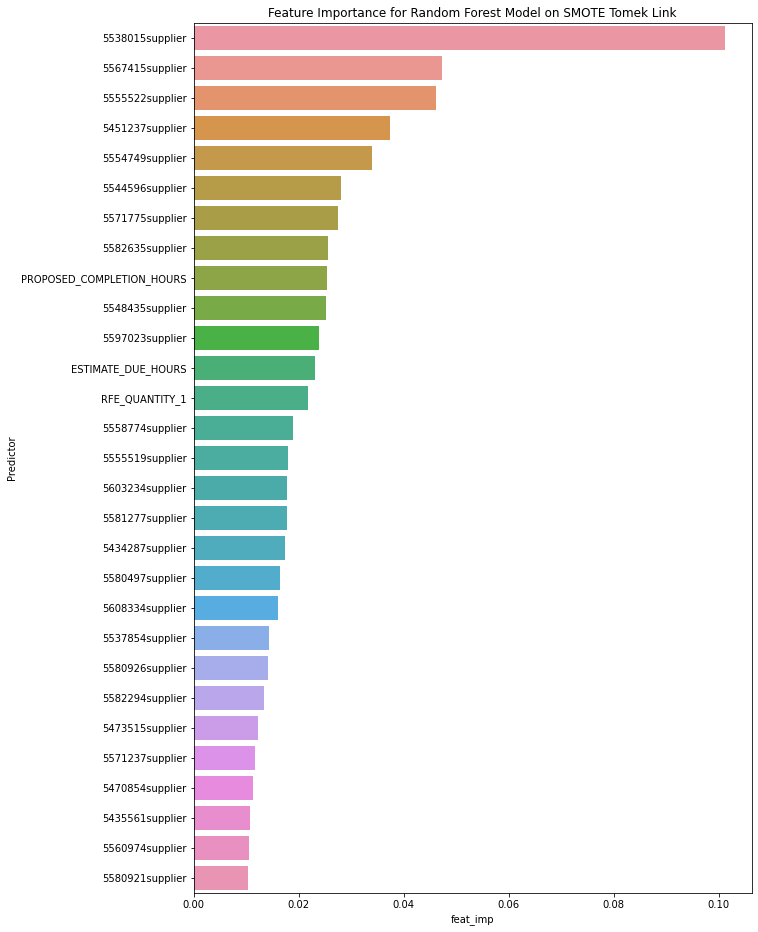

In [40]:
# feature importance for random forest with smote tomek link
plt.figure(figsize=(10,16))
ax = sns.barplot(rf_smo_tl_feat_imp.feat_imp, rf_smo_tl_feat_imp.Predictor)
plt.title('Feature Importance for Random Forest Model on SMOTE Tomek Link')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Feature Importance for Random Forest Model on SMOTE')

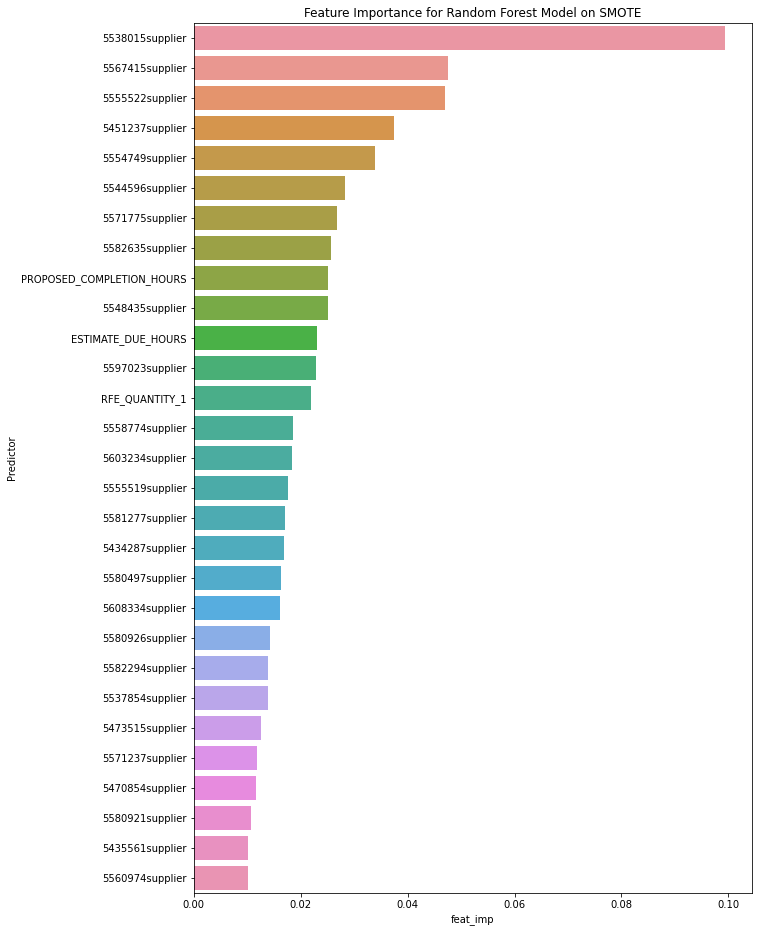

In [41]:
# feature importance for random forest with smote
plt.figure(figsize=(10,16))
ax = sns.barplot(rf_smote_feat_imp.feat_imp, rf_smote_feat_imp.Predictor)
plt.title('Feature Importance for Random Forest Model on SMOTE')

It seems that the only categories that provide more than .01 feature importance for the random forest models are supplier, PROPOSED_COMPLETION_HOURS, ESTIMATE_DUE_HOURS, and RFE_QUANTITY_1.  However, running a random forest model with only these 4 features would drastically reduce the test F_score (to around .58 for both smote and smote tomek link)

We will proceed by looking at the least important categories and iteratively remove them to see if there are improvements.

In [42]:
# Random forest features for SMOTE_TL
rf_smo_tl_least_feat_imp = pd.DataFrame(smo_tl_x.columns, columns=['Predictor'])
rf_smo_tl_least_feat_imp['feat_imp'] = rf_smo_tl.feature_importances_
rf_smo_tl_least_feat_imp.sort_values(['feat_imp'], axis=0, inplace=True)

# Random forest features for Smote
rf_smote_least_feat_imp = pd.DataFrame(smote_x.columns, columns=['Predictor'])
rf_smote_least_feat_imp['feat_imp'] = rf_smote.feature_importances_
rf_smote_least_feat_imp.sort_values(['feat_imp'], axis=0, inplace=True)

In [43]:
# Removing the categories of supplier_id to make the list easier to go through
# Get indices where the category is supplier
sup_cat = [True if i[-8:] != 'supplier' else False for i in rf_smo_tl_least_feat_imp.Predictor]
rf_smo_tl_least_feat_imp[sup_cat]

,Predictor,feat_imp
52,5574299product,0.000000
29,4000228product,0.000004
47,5075056product,0.000009
57,5003313sp_spec,0.000023
50,5478413product,0.000036
...,...,...
36,4000500product,0.006530
4,RFE_QUANTITY_2,0.008801
3,RFE_QUANTITY_1,0.021749
1,ESTIMATE_DUE_HOURS,0.023040


None of the categorical variables will be removed since the presence of a single category being relatively important would mean that the whole

We see that, besides the individual categoricals, the 3 variables with the lowest features importances are, from lowest to highest, RFE_QUANTITY_5, RFE_ITEM_CONUT, RFE_QUANTITY_4.

We can proceed by examining the results of removing different combinations of these three variables.

## Comparing models with different features removed


In [59]:
# getting df with proper encodings and features selected above

# first get list of categorical variables to be one hot encoded
# categorical variables with no missing variables

dummy_cat_rf = ['PRODUCT_TYPE_ID', 'SP_SPEC_TYPE_ID', 'SUPPLIER_USER_ID']
# dummy_cat_rf = ['SUPPLIER_USER_ID']

# # categorical variables with missing variables
dummy_cat_miss_rf = ['month', 'dayofweek']
# dummy_cat_miss_rf = ['dayofweek']

# get list for num variables
num_vars_rf = ['PROPOSED_COMPLETION_HOURS', 'ESTIMATE_DUE_HOURS',
               'RFE_ITEM_CONUT', 'RFE_QUANTITY_1', 'RFE_QUANTITY_2',
               'RFE_QUANTITY_3', 'RFE_QUANTITY_4', 'RFE_QUANTITY_5']

# get the predicted variable
y_rf = df.IS_SUBMIT_ESTIMATE

# initialize df of numerical data
X_rf = df[num_vars_rf]

# dummify categorical variables
# also dropping the first column since the information does not change if
# all the other columns are kept
for i in dummy_cat_rf:
  X_rf = X_rf.join(pd.get_dummies(df[i]).iloc[:, 1:], rsuffix=i)

# dummify categorical variables with missing variables and keeping all columns
for i in dummy_cat_miss_rf:
  X_rf = X_rf.join(pd.get_dummies(df[i]).iloc[:, :], rsuffix=i)

In [60]:
x_train_rf, x_test_rf, y_train_rf, y_test_rf =  train_test_split(X_rf, y_rf,
                                                     test_size=.33,
                                                     random_state = RANDOM_STATE)

# getting training and testing set for the predictor variables with quantity
# filled in with 0s

# dict with columns and what value to fill
# PROPOSED_COMPLETION_HOURS and ESTIMATE_DUE_HOURS will be filled by their mean
# quantity columns will be filled with 0
values = {'PROPOSED_COMPLETION_HOURS' : df['PROPOSED_COMPLETION_HOURS'].mean(),
          'ESTIMATE_DUE_HOURS' : df['ESTIMATE_DUE_HOURS'].mean(),
          'RFE_QUANTITY_2' : 0, 'RFE_QUANTITY_3' : 0, 'RFE_QUANTITY_4' : 0,
          'RFE_QUANTITY_5' : 0}

x_train_rf = x_train_rf.fillna(value = values)
x_test_rf = x_test_rf.fillna(value = values)

In [46]:
# smo_tl = SMOTETomek(random_state=RANDOM_STATE)
# smo_tl_x_rf, smo_tl_y_rf = smo_tl.fit_resample(x_train_rf, y_train_rf)
# smo_tl_x_rf = pd.DataFrame(data = smo_tl_x_rf, columns = x_train_rf.columns)
# smo_tl_y_rf = pd.Series(data=smo_tl_y_rf, name = 'IS_SUBMIT_ESTIMATE')

In [61]:
smote = SMOTE(random_state=RANDOM_STATE)
smote_x_rf, smote_y_rf = smote.fit_resample(x_train_rf, y_train_rf)
smote_x_rf = pd.DataFrame(data=smote_x_rf, columns=x_train_rf.columns)
smote_y_rf = pd.Series(data=smote_y_rf, name = 'IS_SUBMIT_ESTIMATE')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [48]:
# def get_pred_and_scores(cols_to_drop, balanced_x, balanced_y, balancer):
#   name = balancer + '_no_'
#   for i in cols_to_drop:
#     name += i + '_'

#   df_with_dropped = balanced_x.drop(cols_to_drop, axis=1)
#   mod = RandomForestClassifier(random_state=RANDOM_STATE).fit(df_with_dropped,
#                                                               balanced_y)
#   train_pred = mod.predict(df_with_dropped)
#   test_pred = mod.predict(x_test_rf.drop(cols_to_drop, axis=1))

#   out = get_scores(train_pred, test_pred, balanced_y, y_test_rf,
#                    'rf', name)
  
#   return out

In [49]:
# best_scores = all_scores.iloc[[16,4], :]
# best_scores

In [50]:
# # Removing RFE_ITEM_CONUT

# print('training smo_tl')
# smo_tl_no_item_conut = get_pred_and_scores(['RFE_ITEM_CONUT'], smo_tl_x_rf, smo_tl_y_rf, 'smo_tl')
# print('training smote')
# smote_no_item_conut = get_pred_and_scores(['RFE_ITEM_CONUT'], smote_x_rf, smote_y_rf, 'smote')

# best_scores = best_scores.append(smo_tl_no_item_conut)
# best_scores = best_scores.append(smote_no_item_conut)

In [51]:
# # Removing RFE_QUANTITY_5

# print('training smo_tl')
# smo_tl_no_quant5 = get_pred_and_scores(['RFE_QUANTITY_5'], smo_tl_x_rf, smo_tl_y_rf, 'smo_tl')
# print('training smote')
# smote_no_quant5 = get_pred_and_scores(['RFE_QUANTITY_5'], smote_x_rf, smote_y_rf, 'smote')

# best_scores = best_scores.append(smo_tl_no_quant5)
# best_scores = best_scores.append(smote_no_quant5)

In [52]:
# # Removing RFE_QUANTITY_4

# print('training smo_tl')
# smo_tl_no_quant4 = get_pred_and_scores(['RFE_QUANTITY_4'], smo_tl_x_rf, smo_tl_y_rf, 'smo_tl')
# print('training smote')
# smote_no_quant4 = get_pred_and_scores(['RFE_QUANTITY_4'], smote_x_rf, smote_y_rf, 'smote')

# best_scores = best_scores.append(smo_tl_no_quant4)
# best_scores = best_scores.append(smote_no_quant4)

In [53]:
# # Removing and RFE_ITEM_CONUT and RFE_QUANTITY_4

# print('training smote')
# smote_no_quant4_conut = get_pred_and_scores(['RFE_ITEM_CONUT', 'RFE_QUANTITY_4'], smote_x_rf, smote_y_rf, 'smote')
# print('training smo_tl')
# smo_tl_no_quant4_conut = get_pred_and_scores(['RFE_ITEM_CONUT', 'RFE_QUANTITY_4'], smo_tl_x_rf, smo_tl_y_rf, 'smo_tl')

# best_scores = best_scores.append(smote_no_quant4_conut)
# best_scores = best_scores.append(smo_tl_no_quant4_conut)

In [54]:
# best_scores.to_csv('feature_eng_scores.csv')

In [55]:
best_scores = pd.read_csv('feature_eng_scores.csv')
best_scores.set_index(['Model_version', 'Model']).sort_values('Test_fscore',
                                                              ascending=False)

Unnamed: 0  ...  Test_fscore
Model_version                            Model              ...             
smote_no_RFE_ITEM_CONUT_                 rf              0  ...     0.651263
smote_no_RFE_QUANTITY_4_                 rf              0  ...     0.648199
smo_tl_no_RFE_ITEM_CONUT_RFE_QUANTITY_4_ rf              0  ...     0.648034
                                         rf              0  ...     0.648034
smote_no_RFE_ITEM_CONUT_RFE_QUANTITY_4_  rf              0  ...     0.647654
                                         rf              0  ...     0.647654
smo_tl_no_RFE_QUANTITY_5_                rf              0  ...     0.647566
smote_no_RFE_QUANTITY_5_                 rf              0  ...     0.647508
smo_tl_no_RFE_ITEM_CONUT_                rf              0  ...     0.647349
smo_tl                                   rf              0  ...     0.647059
smote                                    rf              0  ...     0.645241
smo_tl_no_RFE_QUANTITY_4_                rf              0  ...     0.641160

[12 rows x 9 columns]

Unlike with RFE_QUANTITY_5, removing only RFE_ITEM CONUT and only RFE_QUANTITY_4 both led to improvements in the model.

Therefore, we also looked at removing both RFE_ITEM_CONUT and RFE_QUANITYT_4, though that did not peform as well.

Our best model happens to be a random forest algorithm trained on SMOTE balanced data with only RFE_ITEM_CONUT removed, and this will be our final model.

## Final models

Here will train our final model.

In [63]:
  df_with_dropped = smote_x_rf.drop('RFE_ITEM_CONUT', axis=1)
  fin_mod = RandomForestClassifier(random_state=RANDOM_STATE)
  fin_mod.fit(df_with_dropped,smote_y_rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=99, verbose=0,
                       warm_start=False)

# Looking at variable effects on IS_SUBMIT_ESTIMATE


With our model built, we can look into some of the important variables and how they affect the probability of IS_SUBMIT_ESTIMATE.  This will all be done with the original, unchanged dataframe.

We can look at the top 4 categories from the feature engineering section, which would be supplier, PROPOSED_COMPLETION_HOURS, ESTIMATE_DUE_HOURS, and RFE_QUANTITY_1.

## Supplier

As it seems to be the most important variable, we will take a look at the supplier ID's and their effects on IS_SUBMIT_ESTIMATE first.

As there are so many different supplier IDs, we will only look at the suppliers that have more than 500 instances, which happens to be the top 25 most common suppliers.

In [91]:
print(f'Number of different SUPPLIER_USER_IDs in the dataset is {len(set(df.SUPPLIER_USER_ID))}')

Number of different SUPPLIER_USER_IDs in the dataset is 358


In [129]:
# taken out 'supplier' from the variable so it is easier to read when plotted
df['SUPPLIER_USER_ID'] = [i[:7] for i in df['SUPPLIER_USER_ID']]

In [130]:
# get all supplier ids that occur more than 500 times


sup_counts = df.SUPPLIER_USER_ID.value_counts()
sup_counts = sup_counts[sup_counts > 500]

In [131]:
# get df with supplier ids and IS_SUBMIT_ESTMATE
# from the ids taken above
sup_df = df[df.SUPPLIER_USER_ID.isin(sup_counts.index)][['SUPPLIER_USER_ID', 'IS_SUBMIT_ESTIMATE']]

Text(0.5, 1.0, 'Percentage of RFEs where supplier returned an estimate, by supplier')

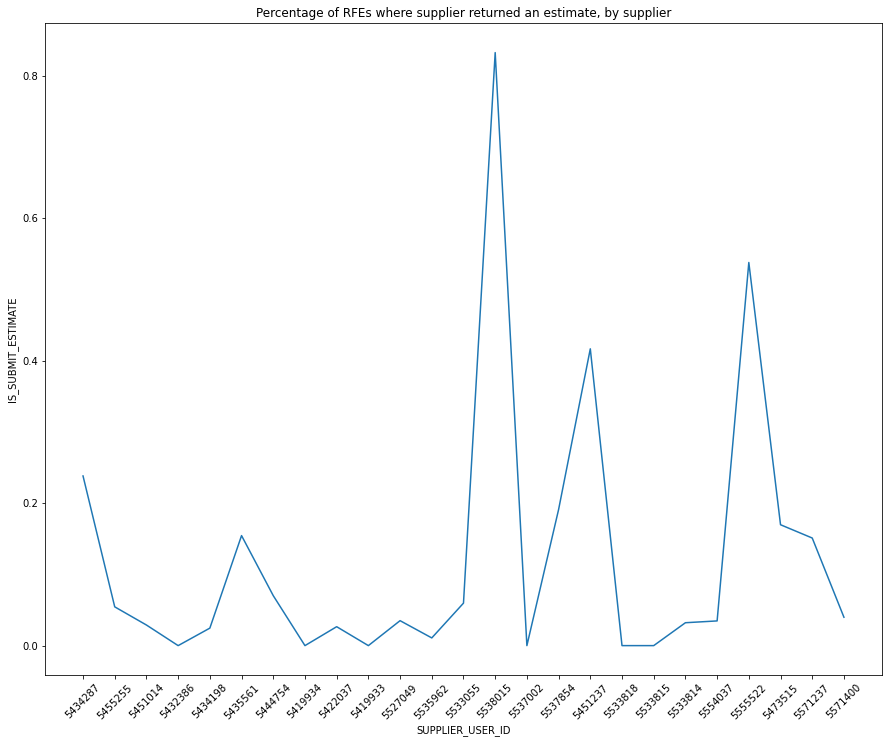

In [135]:
plt.figure(figsize = (15,12))
ax = sns.lineplot(x=sup_df.SUPPLIER_USER_ID,
                  y=sup_df.IS_SUBMIT_ESTIMATE, ci = None)
for ticker in ax.get_xticklabels():
  ticker.set_rotation(45)
plt.title('Percentage of RFEs where supplier returned an estimate, by supplier')

From this plot, we can see, for each supplier, the percentage of RFE's that have a IS_SUBMIT_RESPONSE of 1.  The most consistent supplier ID's are 5538015, 5451237, and 5555522.



# RFE_QUANTITY_1

Since this quantity is a numerical variable, the line plot from above won't work as well, so we will bin the variables and use the lineplot on those bins. 

In [143]:
df.describe()

,PROPOSED_COMPLETION_HOURS,ESTIMATE_DUE_HOURS,RFE_ITEM_CONUT,RFE_QUANTITY_1,RFE_QUANTITY_2,RFE_QUANTITY_3,RFE_QUANTITY_4,RFE_QUANTITY_5,IS_SUBMIT_ESTIMATE
count,68423.000000,68423.000000,69101.000000,69101.000000,1.949000e+04,9580.000000,3156.000000,360.000000,69101.000000
mean,1386.057758,85.748067,1.023097,34818.207247,3.677723e+04,34453.563987,36070.888466,11681.472222,0.081793
std,844.253928,54.569768,0.150212,92428.755904,1.249910e+05,68529.517224,71840.947926,13051.385968,0.274052
min,22.000000,0.000000,1.000000,1.000000,2.000000e+00,3.000000,4.000000,5.000000,0.000000
25%,798.000000,48.000000,1.000000,1691.000000,1.500000e+03,1000.000000,1000.000000,100.000000,0.000000
50%,1226.000000,73.000000,1.000000,6000.000000,6.300000e+03,5000.000000,6000.000000,7000.000000,0.000000
75%,1781.000000,116.000000,1.000000,20000.000000,2.000000e+04,30000.000000,30000.000000,9000.000000,0.000000
max,9791.000000,504.000000,2.000000,800000.000000,1.244000e+06,500000.000000,380000.000000,35000.000000,1.000000


From the above, we see that the max RFE_QUANTITY_1 is 800,000 and the minimum is 1.  So by using 8 bins, the observations will be grouped together by 100,000.
For example, all observations with quantity between 0 and 100,000 will be grouped together.  This will make it easier to read a lineplot.

We will look at the plots binning with 8 and 16.

Text(0.5, 1.0, 'Binning by 50,000s for quantity')

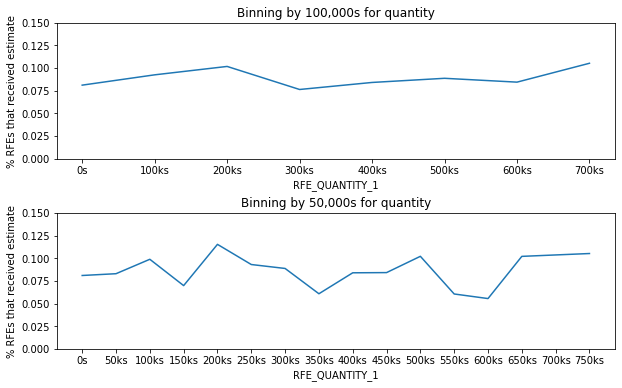

In [163]:
plt.figure(figsize = (10,6))
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=.4)
sns.lineplot(x=pd.cut(df.RFE_QUANTITY_1, 8,
                      labels=['0s', '100ks', '200ks', '300ks', '400ks',
                              '500ks', '600ks', '700ks']),
             y=df.IS_SUBMIT_ESTIMATE, ci=None)
plt.ylim([0, .15])
plt.ylabel('% RFEs that received estimate')
plt.title('Binning by 100,000s for quantity')
plt.subplot(2,1,2)
sns.lineplot(x=pd.cut(df.RFE_QUANTITY_1, 16,
                      labels=['0s', '50ks', '100ks', '150ks', '200ks', '250ks',
                              '300ks', '350ks', '400ks', '450ks', '500ks',
                              '550ks', '600ks', '650ks', '700ks', '750ks']),
             y=df.IS_SUBMIT_ESTIMATE, ci=None)
plt.ylim([0, .15])
plt.ylabel('% RFEs that received estimate')
plt.title('Binning by 50,000s for quantity')

From the above, we can see the percentage of of RFEs that received an estimate from suppliers.  We can see that the an RFE with around 200,000s quantity recieve the most responses. while 150,000s, 350,000s, and 600,000s receive the least.

##  PROPOSED_COMPLETION_HOURS

We can use similar steps for PROPOSED_COMPLETION_HOURS as we did with quantity.

However, we must also fill in the missing variables for this category.

As this variable ranges from 22 to 9791, we can split it into 10 or 20 bins, so it is by roughly 500 or 1000.

In [178]:
values = {'PROPOSED_COMPLETION_HOURS' : df['PROPOSED_COMPLETION_HOURS'].mean(),
          'ESTIMATE_DUE_HOURS' : df['ESTIMATE_DUE_HOURS'].mean()}

df = df.fillna(value=values)

Text(0.5, 1.0, 'Binning by 50,000s for quantity')

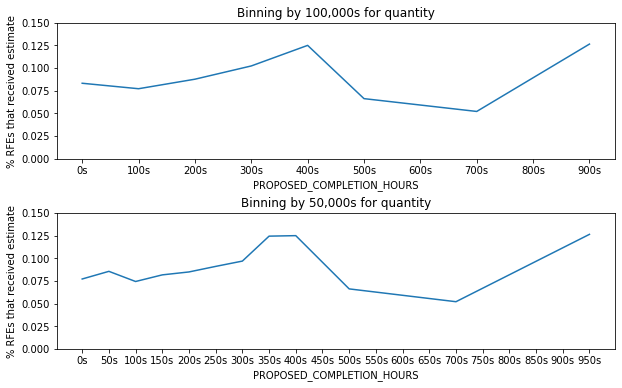

In [180]:
plt.figure(figsize = (10,6))
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=.4)
ax = sns.lineplot(x=pd.cut(df.PROPOSED_COMPLETION_HOURS, 10,
                      labels=['0s', '100s', '200s', '300s', '400s', '500s',
                              '600s', '700s', '800s', '900s']),
             y=df.IS_SUBMIT_ESTIMATE, ci=None)
plt.ylim([0, .15])
plt.ylabel('% RFEs that received estimate')
plt.title('Binning by 100s for proposed completion hours')
plt.subplot(2,1,2)
sns.lineplot(x=pd.cut(df.PROPOSED_COMPLETION_HOURS, 20,
                      labels=['0s', '50s', '100s', '150s', '200s', '250s',
                              '300s', '350s', '400s', '450s', '500s',
                              '550s', '600s', '650s', '700s', '750s',
                              '800s', '850s', '900s', '950s']),
             y=df.IS_SUBMIT_ESTIMATE, ci=None)
plt.ylim([0, .15])
plt.ylabel('% RFEs that received estimate')
plt.title('Binning by 50s for proposed completion hours')

In [179]:
np.percentile(df.PROPOSED_COMPLETION_HOURS, 80)

1946.0

## ESTIMATE_DUE_HOURS


Lastly, we will look at estimate due hours.  This ranges from 0 to 504, so we can do 5 or 10 bins to go by 100s or 50s.

In [ ]:
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=.4)
ax = sns.lineplot(x=pd.cut(df.ESTIMATE_DUE_HOURS[], 5,
                      labels=['0s', '100s', '200s', '300s', '400s']),
             y=df.IS_SUBMIT_ESTIMATE, ci=None)
plt.ylim([0, .15])
plt.ylabel('% RFEs that received estimate')
plt.title('Binning by 100s for estimate due hours')')

Text(0.5, 1.0, 'Binning by 50,000s for quantity')

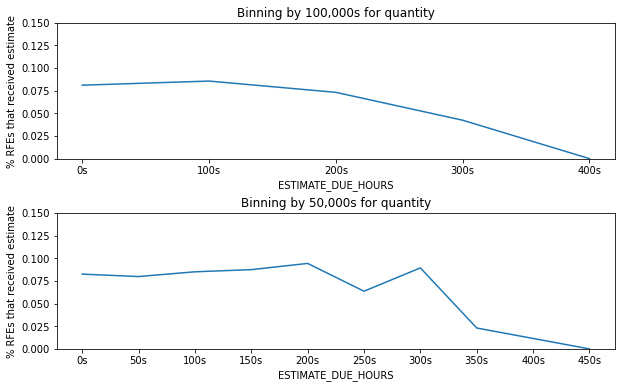

In [183]:
plt.figure(figsize = (10,6))
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=.4)
ax = sns.lineplot(x=pd.cut(df.ESTIMATE_DUE_HOURS, 5,
                      labels=['0s', '100s', '200s', '300s', '400s']),
             y=df.IS_SUBMIT_ESTIMATE, ci=None)
plt.ylim([0, .15])
plt.ylabel('% RFEs that received estimate')
plt.title('Binning by 100s for estimate due hours')')
plt.subplot(2,1,2)
sns.lineplot(x=pd.cut(df.ESTIMATE_DUE_HOURS, 10,
                      labels=['0s', '50s', '100s', '150s', '200s', '250s',
                              '300s', '350s', '400s', '450s']),
             y=df.IS_SUBMIT_ESTIMATE, ci=None)
plt.ylim([0, .15])
plt.ylabel('% RFEs that received estimate')
plt.title('Binning by 50s for estimate due hours')

Here we can see how the percentage of RFEs that receive an estimate decreases the more the estimate hour increases.